
Initial dataset shape: (4809, 23)

Sample of merged data:
                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                              genres  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   

                                                crew  \
0  [{"credit_id": "52fe48009251416c750aca23", "de...   
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...   

                                            overview  
0  In the 22nd century, a paraplegic Marine is di...  
1  Captain Barbossa, long believed to be dead, ha...  

After preprocessing features:
                                      title                    genres  \
0                      

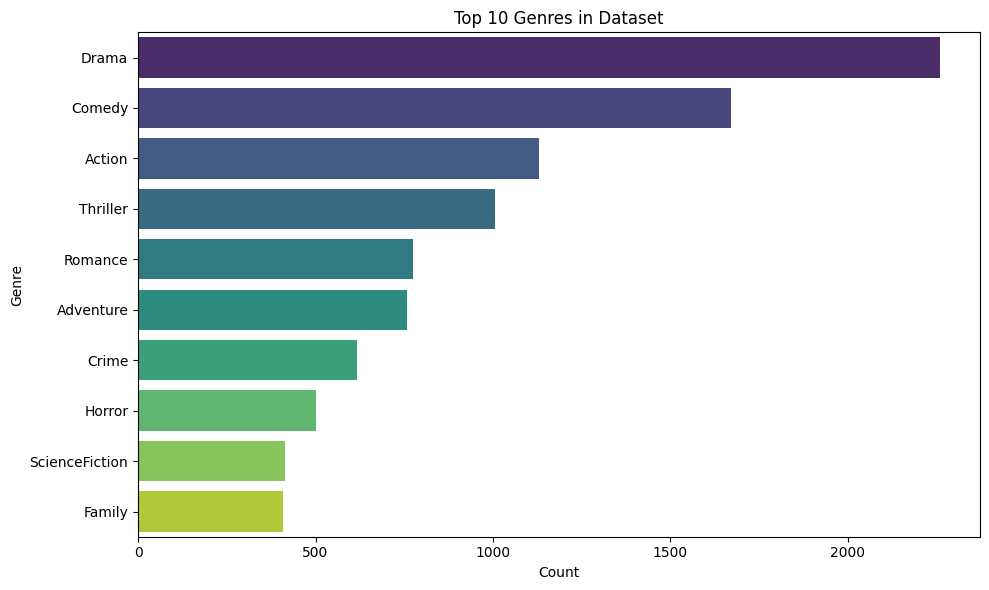


Content-Based Recommendations for 'Avatar':
                     title  vote_average                          genres
3607             Apollo 18           5.0  Horror Thriller ScienceFiction
942       The Book of Life           7.3     Romance Animation Adventure
2132          The American           5.8            Crime Drama Thriller
1342  The Inhabited Island           5.3   Action Fantasy ScienceFiction
634             The Matrix           7.9           Action ScienceFiction

Collaborative Recommendations for 'user1':
         title     score
0  John Carter  1.420094

Hybrid Recommendations for 'user1' based on 'Avatar':
                  title     score
5            The Matrix  0.600000
1           John Carter  0.568038
3      The Book of Life  0.475862
2          The American  0.165517
4  The Inhabited Island  0.062069


In [12]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Load and merge datasets
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')
df = movies_df.merge(credits_df, on='title')

print("\nInitial dataset shape:", df.shape)
print("\nSample of merged data:")
print(df[['title', 'genres', 'cast', 'crew', 'overview']].head(2))

# Extract relevant features
def extract_names(obj, key='name', limit=3):
    try:
        items = ast.literal_eval(obj)
        return ' '.join([item[key].replace(" ", "") for item in items[:limit]])
    except:
        return ''

df['genres'] = df['genres'].apply(lambda x: extract_names(x))
df['cast'] = df['cast'].apply(lambda x: extract_names(x))
df['crew'] = df['crew'].apply(lambda x: extract_names(x, key='job', limit=1) if 'Director' in x else '')
df['overview'] = df['overview'].fillna('')

# Preview preprocessing steps
print("\nAfter preprocessing features:")
print(df[['title', 'genres', 'cast', 'crew', 'overview']].head(2))

# Combine features
df['features'] = df['genres'] + ' ' + df['cast'] + ' ' + df['crew'] + ' ' + df['overview']
print("\nCombined feature sample:")
print(df[['title', 'features']].head(2))

# Visualization: Top 10 genres by frequency
genre_counts = pd.Series(' '.join(df['genres']).split()).value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, hue=genre_counts.index, dodge=False, palette='viridis', legend=False)
plt.title('Top 10 Genres in Dataset')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

# Vectorize and calculate similarity
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
title_to_index = pd.Series(df.index, index=df['title'])

# Content-based recommendation
def get_content_based_recommendations(title, top_n=5):
    if title not in title_to_index:
        return "Movie not found."
    idx = title_to_index[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return df[['title', 'vote_average', 'genres']].iloc[movie_indices]

# Sample user ratings
user_ratings = {
    'user1': {'Avatar': 5, 'Spectre': 3, 'The Dark Knight Rises': 4},
    'user2': {'Avatar': 4, 'Spectre': 2, 'The Dark Knight Rises': 5},
    'user3': {'Avatar': 3, 'Spectre': 4, 'The Dark Knight Rises': 2},
    'user4': {'John Carter': 5, 'Avatar': 1, 'Spectre': 2},
}

# Collaborative recommendation
def get_collaborative_recommendations(user_id, top_n=5):
    if user_id not in user_ratings:
        return "User not found."
    user_item_matrix = pd.DataFrame(user_ratings).fillna(0)
    user_similarity = cosine_similarity(user_item_matrix.T)
    user_idx = list(user_ratings.keys()).index(user_id)
    similar_users = sorted(list(enumerate(user_similarity[user_idx])), key=lambda x: x[1], reverse=True)[1:4]
    recommendations = {}
    for idx, sim in similar_users:
        other_user = list(user_ratings.keys())[idx]
        for movie, rating in user_ratings[other_user].items():
            if movie not in user_ratings[user_id]:
                if movie not in recommendations:
                    recommendations[movie] = {'score': 0, 'count': 0}
                recommendations[movie]['score'] += rating * sim
                recommendations[movie]['count'] += 1
    if not recommendations:
        return pd.DataFrame(columns=['title', 'score'])
    rec_list = [(movie, data['score'] / data['count']) for movie, data in recommendations.items()]
    return pd.DataFrame(rec_list, columns=['title', 'score']).sort_values('score', ascending=False).head(top_n)

# Hybrid recommendation
def get_hybrid_recommendations(user_id, title, top_n=5):
    content_recs = get_content_based_recommendations(title, top_n)
    collab_recs = get_collaborative_recommendations(user_id, top_n)
    if isinstance(content_recs, str) or collab_recs.empty:
        return content_recs if isinstance(content_recs, str) else collab_recs
    scaler = MinMaxScaler()
    content_recs['score_content'] = scaler.fit_transform(content_recs[['vote_average']])
    hybrid_recs = pd.merge(content_recs, collab_recs, on='title', how='outer')
    hybrid_recs['score'] = 0.6 * hybrid_recs['score_content'].fillna(0) + 0.4 * hybrid_recs['score'].fillna(0)
    return hybrid_recs[['title', 'score']].sort_values('score', ascending=False).head(top_n)

# Example usage
print("\nContent-Based Recommendations for 'Avatar':")
print(get_content_based_recommendations('Avatar'))

print("\nCollaborative Recommendations for 'user1':")
print(get_collaborative_recommendations('user1'))

print("\nHybrid Recommendations for 'user1' based on 'Avatar':")
print(get_hybrid_recommendations('user1', 'Avatar'))
